Processed dataset loaded: (14634, 66)
Generating EDA visualizations with percentage labels...


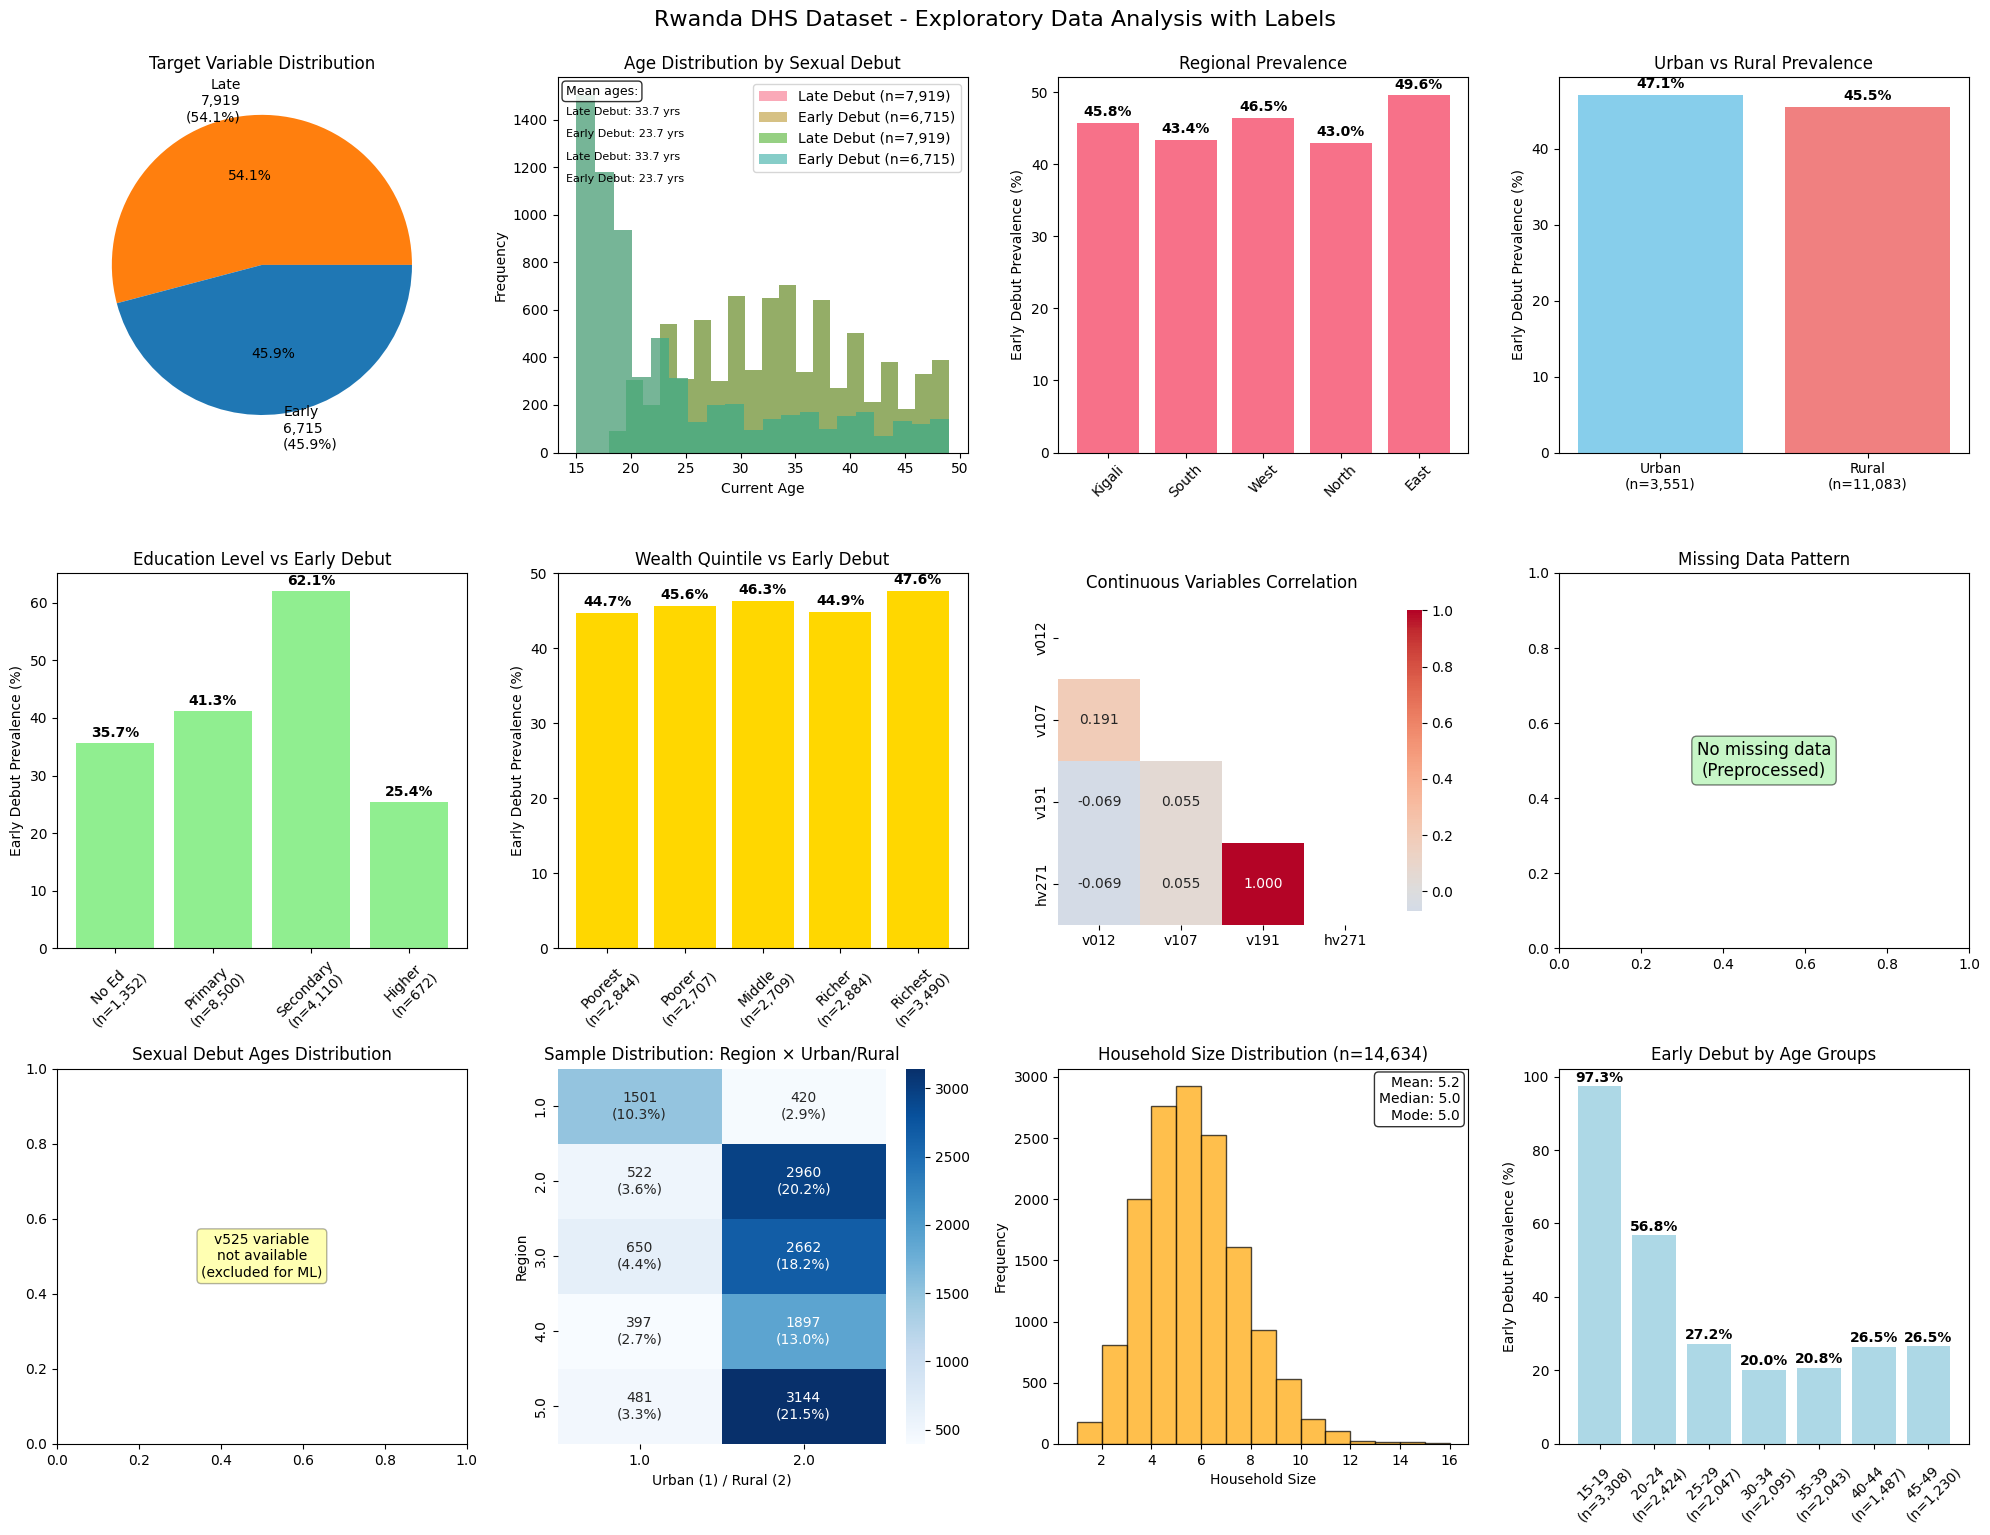

Enhanced EDA visualizations completed successfully!


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

def create_eda_visualizations_with_labels(df, exclude_features=None):
    """
    Create comprehensive visualizations for EDA with percentage labels
    """
    
    # Set up the plotting area
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Target variable distribution
    plt.subplot(3, 4, 1)
    target_counts = df['early_sexual_debut'].value_counts(dropna=False)
    colors = ['#ff7f0e', '#1f77b4', '#2ca02c']
    
    # Calculate percentages
    target_pct = (target_counts / len(df)) * 100
    
    labels = []
    for val in target_counts.index:
        if pd.isna(val):
            labels.append(f'NaN\n{target_counts[val]:,}\n({target_pct[val]:.1f}%)')
        else:
            label_map = {0.0: 'Late', 1.0: 'Early', 0: 'Late', 1: 'Early'}
            label_text = label_map.get(val, str(val))
            labels.append(f'{label_text}\n{target_counts[val]:,}\n({target_pct[val]:.1f}%)')
    
    plt.pie(target_counts.values, labels=labels, autopct='%1.1f%%', 
            colors=colors[:len(target_counts)])
    plt.title('Target Variable Distribution')
    
    # 2. Age distribution by target
    if 'v012' in df.columns:
        plt.subplot(3, 4, 2)
        age_data = []
        for debut_status in [0.0, 1.0, 0, 1]:
            subset = df[df['early_sexual_debut'] == debut_status]['v012']
            if len(subset) > 0:
                label = 'Early Debut' if debut_status in [1.0, 1] else 'Late Debut'
                plt.hist(subset, alpha=0.6, bins=20, label=f'{label} (n={len(subset):,})')
                age_data.append((label, len(subset), subset.mean()))
        
        plt.xlabel('Current Age')
        plt.ylabel('Frequency')
        plt.title('Age Distribution by Sexual Debut')
        plt.legend()
        
        # Add mean age annotations
        plt.text(0.02, 0.98, f'Mean ages:', transform=plt.gca().transAxes, 
                verticalalignment='top', fontsize=9,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        y_pos = 0.90
        for label, count, mean_age in age_data:
            if not pd.isna(mean_age):
                plt.text(0.02, y_pos, f'{label}: {mean_age:.1f} yrs', 
                        transform=plt.gca().transAxes, fontsize=8)
                y_pos -= 0.06
    
    # 3. Regional prevalence with labels
    if 'v101' in df.columns:
        plt.subplot(3, 4, 3)
        
        region_data = []
        region_names = []
        region_labels_map = {1: 'Kigali', 2: 'South', 3: 'West', 4: 'North', 5: 'East'}
        
        for region_code in sorted(df['v101'].dropna().unique()):
            if not pd.isna(region_code):
                region_code = int(region_code)
                subset = df[df['v101'] == region_code]['early_sexual_debut']
                valid_cases = subset.dropna()
                
                if len(valid_cases) > 0:
                    prevalence = (valid_cases == 1.0).mean() * 100
                    region_data.append(prevalence)
                    region_names.append(region_labels_map.get(region_code, f'Region{region_code}'))
        
        if region_data:
            bars = plt.bar(range(len(region_data)), region_data)
            plt.xticks(range(len(region_data)), region_names, rotation=45)
            plt.ylabel('Early Debut Prevalence (%)')
            plt.title('Regional Prevalence')
            
            # Add percentage labels on bars
            for i, (bar, value) in enumerate(zip(bars, region_data)):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 4. Urban vs Rural with labels
    if 'v102' in df.columns:
        plt.subplot(3, 4, 4)
        
        urban_rural_data = []
        urban_rural_labels = []
        counts = []
        
        for area_code in sorted(df['v102'].dropna().unique()):
            if not pd.isna(area_code):
                area_code = int(area_code)
                subset = df[df['v102'] == area_code]['early_sexual_debut']
                valid_cases = subset.dropna()
                
                if len(valid_cases) > 0:
                    prevalence = (valid_cases == 1.0).mean() * 100
                    urban_rural_data.append(prevalence)
                    area_name = 'Urban' if area_code == 1 else 'Rural'
                    urban_rural_labels.append(f'{area_name}\n(n={len(valid_cases):,})')
                    counts.append(len(valid_cases))
        
        if urban_rural_data:
            colors = ['skyblue', 'lightcoral'][:len(urban_rural_data)]
            bars = plt.bar(urban_rural_labels, urban_rural_data, color=colors)
            plt.ylabel('Early Debut Prevalence (%)')
            plt.title('Urban vs Rural Prevalence')
            
            # Add percentage labels
            for bar, value in zip(bars, urban_rural_data):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 5. Education level association with labels
    if 'v106' in df.columns:
        plt.subplot(3, 4, 5)
        
        edu_data = []
        edu_labels_map = {0: 'No Ed', 1: 'Primary', 2: 'Secondary', 3: 'Higher'}
        edu_names = []
        edu_counts = []
        
        for edu_code in sorted(df['v106'].dropna().unique()):
            if not pd.isna(edu_code):
                edu_code = int(edu_code)
                subset = df[df['v106'] == edu_code]['early_sexual_debut']
                valid_cases = subset.dropna()
                
                if len(valid_cases) > 0:
                    prevalence = (valid_cases == 1.0).mean() * 100
                    edu_data.append(prevalence)
                    edu_names.append(f"{edu_labels_map.get(edu_code, f'Level{edu_code}')}\n(n={len(valid_cases):,})")
                    edu_counts.append(len(valid_cases))
        
        if edu_data:
            bars = plt.bar(range(len(edu_data)), edu_data, color='lightgreen')
            plt.xticks(range(len(edu_data)), edu_names, rotation=45)
            plt.ylabel('Early Debut Prevalence (%)')
            plt.title('Education Level vs Early Debut')
            
            # Add percentage labels
            for bar, value in zip(bars, edu_data):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 6. Wealth quintile association with labels
    if 'v190' in df.columns:
        plt.subplot(3, 4, 6)
        
        wealth_data = []
        wealth_labels = ['Poorest', 'Poorer', 'Middle', 'Richer', 'Richest']
        wealth_counts = []
        
        for wealth_code in range(1, 6):
            subset = df[df['v190'] == wealth_code]['early_sexual_debut']
            valid_cases = subset.dropna()
            
            if len(valid_cases) > 0:
                prevalence = (valid_cases == 1.0).mean() * 100
                wealth_data.append(prevalence)
                wealth_counts.append(len(valid_cases))
            else:
                wealth_data.append(0)
                wealth_counts.append(0)
        
        # Update labels with counts
        wealth_labels_with_n = [f'{label}\n(n={count:,})' for label, count in zip(wealth_labels, wealth_counts)]
        
        bars = plt.bar(range(len(wealth_data)), wealth_data, color='gold')
        plt.xticks(range(len(wealth_data)), wealth_labels_with_n, rotation=45)
        plt.ylabel('Early Debut Prevalence (%)')
        plt.title('Wealth Quintile vs Early Debut')
        
        # Add percentage labels
        for bar, value in zip(bars, wealth_data):
            if value > 0:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # 7. Correlation heatmap with values
    plt.subplot(3, 4, 7)
    continuous_vars = ['v012', 'v107', 'v191', 'hv271']
    continuous_present = [var for var in continuous_vars if var in df.columns]
    
    if len(continuous_present) > 1:
        corr_matrix = df[continuous_present].corr()
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Show only lower triangle
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, cbar_kws={'shrink': 0.8}, mask=mask, fmt='.3f')
        plt.title('Continuous Variables Correlation')
    else:
        plt.text(0.5, 0.5, 'Insufficient continuous\nvariables for correlation', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Correlation Matrix')
    
    # 8. Missing data pattern with percentages
    plt.subplot(3, 4, 8)
    missing_data = df.isnull().sum().sort_values(ascending=False)
    if missing_data.sum() > 0:
        top_missing = missing_data[missing_data > 0][:10]
        if len(top_missing) > 0:
            missing_pct = (top_missing / len(df)) * 100
            
            bars = plt.barh(range(len(top_missing)), top_missing.values)
            plt.yticks(range(len(top_missing)), top_missing.index)
            plt.xlabel('Missing Count')
            plt.title('Top Variables with Missing Data')
            
            # Add percentage labels
            for i, (bar, count, pct) in enumerate(zip(bars, top_missing.values, missing_pct.values)):
                width = bar.get_width()
                plt.text(width + 50, bar.get_y() + bar.get_height()/2,
                        f'{pct:.1f}%', ha='left', va='center', fontsize=8)
        else:
            plt.text(0.5, 0.5, 'No missing data', ha='center', va='center', 
                    transform=plt.gca().transAxes)
            plt.title('Missing Data Pattern')
    else:
        plt.text(0.5, 0.5, 'No missing data\n(Preprocessed)', ha='center', va='center', 
                transform=plt.gca().transAxes, fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
        plt.title('Missing Data Pattern')
    
    # 9. Age at debut distribution with statistics
    plt.subplot(3, 4, 9)
    if 'v525' in df.columns:
        debut_ages = df[df['v525'].between(8, 30, inclusive='both')]['v525']
        if len(debut_ages) > 0:
            n, bins, patches = plt.hist(debut_ages, bins=22, alpha=0.7, color='purple', edgecolor='black')
            plt.axvline(x=18, color='red', linestyle='--', linewidth=2, label='18-year cutoff')
            
            # Calculate statistics
            mean_age = debut_ages.mean()
            median_age = debut_ages.median()
            early_count = (debut_ages < 18).sum()
            late_count = (debut_ages >= 18).sum()
            
            plt.xlabel('Age at First Sexual Intercourse')
            plt.ylabel('Frequency')
            plt.title(f'Sexual Debut Ages (n={len(debut_ages):,})')
            plt.legend()
            
            # Add statistics box
            stats_text = f'Mean: {mean_age:.1f}\nMedian: {median_age:.1f}\n<18: {early_count:,} ({early_count/len(debut_ages)*100:.1f}%)\n≥18: {late_count:,} ({late_count/len(debut_ages)*100:.1f}%)'
            plt.text(0.98, 0.98, stats_text, transform=plt.gca().transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                    fontsize=8)
        else:
            plt.text(0.5, 0.5, 'v525 data not available\nor out of range', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Sexual Debut Ages Distribution')
    else:
        plt.text(0.5, 0.5, 'v525 variable\nnot available\n(excluded for ML)', 
                ha='center', va='center', transform=plt.gca().transAxes,
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))
        plt.title('Sexual Debut Ages Distribution')
    
    # 10. Sample distribution heatmap with annotations
    if 'v101' in df.columns and 'v102' in df.columns:
        plt.subplot(3, 4, 10)
        
        region_urban_data = df[['v101', 'v102']].dropna()
        if len(region_urban_data) > 0:
            contingency_table = pd.crosstab(region_urban_data['v101'], 
                                          region_urban_data['v102'])
            
            # Calculate percentages
            pct_table = contingency_table.div(contingency_table.sum().sum()) * 100
            
            # Create annotations with both counts and percentages
            annot_array = np.array([[f'{count}\n({pct:.1f}%)' 
                                   for count, pct in zip(row_counts, row_pcts)]
                                  for row_counts, row_pcts in zip(contingency_table.values, pct_table.values)])
            
            sns.heatmap(contingency_table, annot=annot_array, fmt='', cmap='Blues')
            plt.title('Sample Distribution: Region × Urban/Rural')
            plt.xlabel('Urban (1) / Rural (2)')
            plt.ylabel('Region')
        else:
            plt.text(0.5, 0.5, 'No valid geographic data', ha='center', va='center', 
                    transform=plt.gca().transAxes)
            plt.title('Geographic Distribution')
    
    # 11. Household size distribution with statistics
    if 'hv009' in df.columns:
        plt.subplot(3, 4, 11)
        household_sizes = df['hv009'].dropna()
        if len(household_sizes) > 0:
            n, bins, patches = plt.hist(household_sizes, bins=15, alpha=0.7, 
                                      color='orange', edgecolor='black')
            
            # Calculate statistics
            mean_size = household_sizes.mean()
            median_size = household_sizes.median()
            mode_size = household_sizes.mode().iloc[0] if not household_sizes.mode().empty else 'N/A'
            
            plt.xlabel('Household Size')
            plt.ylabel('Frequency')
            plt.title(f'Household Size Distribution (n={len(household_sizes):,})')
            
            # Add statistics
            stats_text = f'Mean: {mean_size:.1f}\nMedian: {median_size:.1f}\nMode: {mode_size}'
            plt.text(0.98, 0.98, stats_text, transform=plt.gca().transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            plt.text(0.5, 0.5, 'No household size data', ha='center', va='center', 
                    transform=plt.gca().transAxes)
            plt.title('Household Size Distribution')
    
    # 12. Target distribution by age groups with labels
    if 'v013' in df.columns:
        plt.subplot(3, 4, 12)
        
        age_group_labels = {1: '15-19', 2: '20-24', 3: '25-29', 4: '30-34', 
                           5: '35-39', 6: '40-44', 7: '45-49'}
        
        age_prev_data = []
        age_labels = []
        age_counts = []
        
        for age_code in sorted(df['v013'].dropna().unique()):
            if not pd.isna(age_code):
                age_code = int(age_code)
                subset = df[df['v013'] == age_code]['early_sexual_debut']
                valid_cases = subset.dropna()
                
                if len(valid_cases) > 0:
                    prevalence = (valid_cases == 1.0).mean() * 100
                    age_prev_data.append(prevalence)
                    age_labels.append(f"{age_group_labels.get(age_code, f'Age{age_code}')}\n(n={len(valid_cases):,})")
                    age_counts.append(len(valid_cases))
        
        if age_prev_data:
            bars = plt.bar(range(len(age_prev_data)), age_prev_data, color='lightblue')
            plt.xticks(range(len(age_prev_data)), age_labels, rotation=45)
            plt.ylabel('Early Debut Prevalence (%)')
            plt.title('Early Debut by Age Groups')
            
            # Add percentage labels
            for bar, value in zip(bars, age_prev_data):
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        else:
            plt.text(0.5, 0.5, 'No valid age group data', ha='center', va='center', 
                    transform=plt.gca().transAxes)
            plt.title('Early Debut by Age Groups')
    
    plt.tight_layout()
    plt.suptitle('Rwanda DHS Dataset - Exploratory Data Analysis with Labels', 
                fontsize=16, y=1.02)
    plt.show()

# Execute the enhanced visualization function
if __name__ == "__main__":
    # Use the processed dataset
    dataset_path = r"C:\Users\USER\Desktop\MUKABUGINGO_THESIS_CODES\ANALYSIS\rwanda_dhs_processed.csv"
    
    try:
        df = pd.read_csv(dataset_path)
        print(f"Processed dataset loaded: {df.shape}")
        
        # Generate enhanced visualizations with labels
        print("Generating EDA visualizations with percentage labels...")
        create_eda_visualizations_with_labels(df)
        
        print("Enhanced EDA visualizations completed successfully!")
        
    except FileNotFoundError:
        print("Processed dataset not found. Please run preprocessing first.")
    except Exception as e:
        print(f"Error: {e}")